In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, SubsetRandomSampler, DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18, resnet50
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transforms for dataset
transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
train_dataset = ImageFolder(root='/home/iai/Desktop/Jeewon/Study/Conference/Active_Learning/data/splitted/train', transform=transform)
test_dataset = ImageFolder(root='/home/iai/Desktop/Jeewon/Study/Conference/Active_Learning/data/splitted/test', transform=transform)

/home/iai/anaconda3/envs/jwanaconda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch.nn as nn
from torchvision.models import resnet18

# Define ResNet model
class ResNet18(nn.Module):
    def __init__(self, num_classes=88):
        super(ResNet18, self).__init__()
        self.resnet18 = torchvision.models.resnet18(pretrained=True)
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.resnet18.conv1(x)
        x = self.resnet18.bn1(x)
        x = self.resnet18.relu(x)
        x = self.resnet18.maxpool(x)

        x = self.resnet18.layer1(x)
        x = self.resnet18.layer2(x)
        x = self.resnet18.layer3(x)
        x = self.resnet18.layer4(x)

        x = self.resnet18.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = ResNet18(num_classes=88).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(model, optimizer, labeled_loader):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    total = 0
    for images, labels in labeled_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        train_acc += (predicted == labels).sum().item()
    train_loss /= len(labeled_loader)
    train_acc /= total
    return train_loss, train_acc

In [3]:
# Active learning loop
from sklearn.metrics import precision_recall_fscore_support

test_loss_400 = []
test_precision_400 = []
test_recall_400 = []
test_f1_400 = []

num_initial_samples = 400
num_queries = int(len(train_dataset) / 500) # 8
batch_size = 1

# Define initial labeled dataset
labeled_indices = torch.randperm(len(train_dataset))[:num_initial_samples]
labeled_dataset = torch.utils.data.Subset(train_dataset, labeled_indices)

unlabeled_indices = torch.arange(len(train_dataset))[~torch.eq(torch.arange(len(train_dataset)).unsqueeze(1), labeled_indices).any(1)][:500]
unlabeled_dataset = torch.utils.data.Subset(train_dataset, unlabeled_indices)

# Define data loaders
labeled_loader = DataLoader(labeled_dataset, batch_size=32, shuffle=True)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


for query in range(num_queries+1):
    print("Query number:", query+1)
    
    # Train model on labeled dataset
    train_loss, train_acc = train(model, optimizer, labeled_loader)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print("Length of labeled dataset : ",len(labeled_dataset))
    

    # Evaluate model on test dataset
    with torch.no_grad():
        test_loss = 0.0
        test_acc = 0.0
        total = 0
        y_true = []
        y_pred = []
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            test_acc += (predicted == labels).sum().item()
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())
        test_loss /= len(test_loader)
        test_acc /= total
        test_loss_400.append(test_acc)
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=1)
        test_precision_400.append(precision)
        test_recall_400.append(recall)
        test_f1_400.append(f1)
        print(f"Test Precision: {precision:.4f}, Test Recall: {recall:.4f}, Test F1 Score: {f1:.4f}")
    
    if query == (num_queries):
        break
    
    # Make model predictions on unlabeled dataset
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, _ in unlabeled_loader:
            images = images.to(device)
            output = model(images)
            predictions.append(output)
    predictions = torch.cat(predictions, dim=0)

    # # Select samples to label using entropy-based method
    # entropy = -torch.sum(torch.softmax(predictions, dim=1) * torch.log(torch.softmax(predictions, dim=1)), dim=1)
    # _, idx = torch.topk(entropy, k=batch_size * 3)
    # labeled_indices = torch.cat([labeled_indices, unlabeled_indices[idx]])
    # unlabeled_indices = unlabeled_indices[~torch.eq(unlabeled_indices.unsqueeze(1), unlabeled_indices[idx]).any(1)]
    
    # 엔트로피가 0.5 이상인 인덱스를 선택
    entropy = -torch.sum(torch.softmax(predictions, dim=1) * torch.log(torch.softmax(predictions, dim=1)), dim=1)
    idx = torch.where(entropy >= 0.5)[0].to(device)
    # check if indices are empty
    if idx.numel() == 0:
        continue
    # concatenate selected indices to labeled dataset indices
    labeled_indices = torch.cat([labeled_indices, unlabeled_indices[idx]])

    # Update labeled and unlabeled datasets
    if len(train_dataset)-(query+1)*500 > 500:
        unlabeled_indices = torch.arange(len(train_dataset))[~torch.eq(torch.arange(len(train_dataset)).unsqueeze(1), labeled_indices).any(1)][:500]
    else:
        unlabeled_indices = torch.arange(len(train_dataset))[~torch.eq(torch.arange(len(train_dataset)).unsqueeze(1), labeled_indices).any(1)][:len(train_dataset)-4000]
    labeled_dataset = torch.utils.data.Subset(train_dataset, labeled_indices)
    unlabeled_dataset = torch.utils.data.Subset(train_dataset, unlabeled_indices)
    print("Updated Length of labeled dataset : ",len(labeled_dataset))
    print("Length of unlabeled dataset : ",len(unlabeled_dataset))

    # Update labeled and unlabeled data loaders
    labeled_loader = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True)
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True)

Query number: 1
Train Loss: 2.7377, Train Accuracy: 0.5850
Length of labeled dataset :  400
Test Loss: 4.0558, Test Accuracy: 0.1283
Test Precision: 0.3410, Test Recall: 0.1283, Test F1 Score: 0.1077
Updated Length of labeled dataset :  410
Length of unlabeled dataset :  500
Query number: 2
Train Loss: 4.2009, Train Accuracy: 0.0634
Length of labeled dataset :  410
Test Loss: 3.9335, Test Accuracy: 0.0829
Test Precision: 0.8546, Test Recall: 0.0829, Test F1 Score: 0.0129
Updated Length of labeled dataset :  910
Length of unlabeled dataset :  500
Query number: 3
Train Loss: 3.2944, Train Accuracy: 0.2242
Length of labeled dataset :  910
Test Loss: 4.5869, Test Accuracy: 0.0540
Test Precision: 0.9489, Test Recall: 0.0540, Test F1 Score: 0.0055
Updated Length of labeled dataset :  1410
Length of unlabeled dataset :  500
Query number: 4
Train Loss: 3.2008, Train Accuracy: 0.1667
Length of labeled dataset :  1410
Test Loss: 4.7860, Test Accuracy: 0.0588
Test Precision: 0.9446, Test Recall: 

In [4]:
print(test_f1_400)

[0.10770455960147142, 0.012850652002050267, 0.00553359195582302, 0.006535947712418301, 0.023647210410173654, 0.22026394357760143, 0.48681447761042607, 0.5975296277985954, 0.5677937712291901]


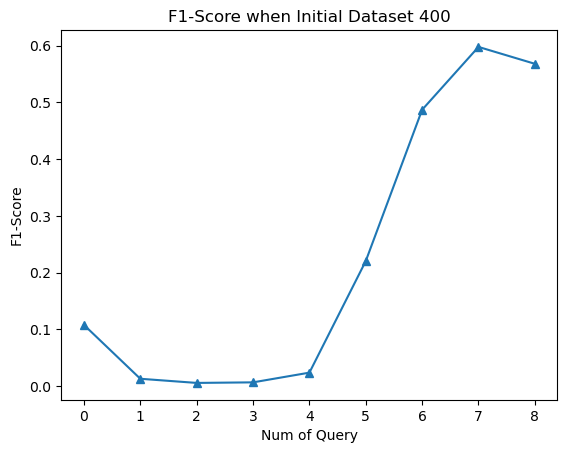

In [5]:
from matplotlib import pyplot as plt 

plt.plot(test_f1_400, marker = '^')
plt.xlabel("Num of Query")
plt.ylabel("F1-Score")
plt.title('F1-Score when Initial Dataset 400')
plt.show()